# Twitter Combat Hate Speech:

In [1]:
import pandas as pd
#import boto3
import re
import warnings
warnings.filterwarnings('ignore')
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
#nltk.download('stopwords')
#nltk.download('punkt')
stop_words = stopwords.words('english')
from string import punctuation
from collections import Counter
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, recall_score, f1_score, precision_score
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv(r'TwitterHate.csv')
df

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
...,...,...,...
31957,31958,0,ate @user isz that youuu?ðððððð...
31958,31959,0,to see nina turner on the airwaves trying to...
31959,31960,0,listening to sad songs on a monday morning otw...
31960,31961,1,"@user #sikh #temple vandalised in in #calgary,..."


In [3]:
df.isnull().sum()

id       0
label    0
tweet    0
dtype: int64

In [4]:
df1 = df[['tweet', 'label']]
df1.columns = ['Tweets', 'Labels']
df1

,Tweets,Labels
0,@user when a father is dysfunctional and is s...,0
1,@user @user thanks for #lyft credit i can't us...,0
2,bihday your majesty,0
3,#model i love u take with u all the time in ...,0
4,factsguide: society now #motivation,0
...,...,...
31957,ate @user isz that youuu?ðððððð...,0
31958,to see nina turner on the airwaves trying to...,0
31959,listening to sad songs on a monday morning otw...,0
31960,"@user #sikh #temple vandalised in in #calgary,...",1


In [5]:
df1.Labels.value_counts()

0    29720
1     2242
Name: Labels, dtype: int64

In [6]:
df1.Labels.value_counts(normalize = True)

0    0.929854
1    0.070146
Name: Labels, dtype: float64

In [7]:
### Loading the tweets text data into a list for easy text cleanup and manipulation :
df_list = df1.Tweets.values.tolist()
type(df_list)

list

In [8]:
df_list[0:4]

[' @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run',
 "@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked",
 '  bihday your majesty',
 '#model   i love u take with u all the time in urð\x9f\x93±!!! ð\x9f\x98\x99ð\x9f\x98\x8eð\x9f\x91\x84ð\x9f\x91\x85ð\x9f\x92¦ð\x9f\x92¦ð\x9f\x92¦  ']

# Cleaning data :

In [9]:
### Normalize the casing :
df_lower = [doc.lower() for doc in df_list]
df_lower[0:4]

[' @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run',
 "@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked",
 '  bihday your majesty',
 '#model   i love u take with u all the time in urð\x9f\x93±!!! ð\x9f\x98\x99ð\x9f\x98\x8eð\x9f\x91\x84ð\x9f\x91\x85ð\x9f\x92¦ð\x9f\x92¦ð\x9f\x92¦  ']

In [10]:
### Removing user handles which are begining with '@’:
df_rem_user = [re.sub(r'@user', '', doc) for doc in df_lower]
df_rem_user[0:5]

['  when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run',
 "  thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked",
 '  bihday your majesty',
 '#model   i love u take with u all the time in urð\x9f\x93±!!! ð\x9f\x98\x99ð\x9f\x98\x8eð\x9f\x91\x84ð\x9f\x91\x85ð\x9f\x92¦ð\x9f\x92¦ð\x9f\x92¦  ',
 ' factsguide: society now    #motivation']

In [11]:
df_rem_user[3]

'#model   i love u take with u all the time in urð\x9f\x93±!!! ð\x9f\x98\x99ð\x9f\x98\x8eð\x9f\x91\x84ð\x9f\x91\x85ð\x9f\x92¦ð\x9f\x92¦ð\x9f\x92¦  '

In [12]:
### Tokenizing tweets into individual terms :
df_token = [word_tokenize(doc) for doc in df_rem_user]

In [13]:
print(df_token[0:2])

[['when', 'a', 'father', 'is', 'dysfunctional', 'and', 'is', 'so', 'selfish', 'he', 'drags', 'his', 'kids', 'into', 'his', 'dysfunction', '.', '#', 'run'], ['thanks', 'for', '#', 'lyft', 'credit', 'i', 'ca', "n't", 'use', 'cause', 'they', 'do', "n't", 'offer', 'wheelchair', 'vans', 'in', 'pdx', '.', '#', 'disapointed', '#', 'getthanked']]


In [14]:
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [15]:
print(len(stop_words))

179


In [16]:
### Removing stop words from the text data :
df_stopwords_rm = []

for doc in df_token:
    df_stopwords_rm.append([word for word in doc if word not in stop_words])
    
print(df_stopwords_rm[0])
print()
print(len(df_stopwords_rm[0]))

['father', 'dysfunctional', 'selfish', 'drags', 'kids', 'dysfunction', '.', '#', 'run']

9


In [17]:
### Punctuation :
punctuations = list(punctuation)
print(punctuations)
print('=' * 100)
print(len(punctuations))

['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~']
32


In [18]:
### Removing punctuations from the text data :
df_punctuation_rm = []

for doc in df_stopwords_rm:
    df_punctuation_rm.append([token for token in doc if token not in punctuations])
    
print(df_punctuation_rm[0])
print()
print(len(df_punctuation_rm[0]))

['father', 'dysfunctional', 'selfish', 'drags', 'kids', 'dysfunction', 'run']

7


In [19]:
### Cleanup by removing terms with a length of 1 :
df_length1_rm = []

for sent in df_punctuation_rm:
    df_length1_rm.append([token for token in sent if len(token) > 1])
    
print(df_length1_rm[0])
print()
print(len(df_length1_rm[0]))

['father', 'dysfunctional', 'selfish', 'drags', 'kids', 'dysfunction', 'run']

7


In [20]:
### Checking for 'amp' and 'rt' words in the text data :
def check_amprt(df_length1_rm):
    remove_list = ['amp', 'rt']
    amprt_list = []
    norm_list = []
    
    for doc in df_length1_rm:
        for token in doc:
            if token in remove_list:
                amprt_list.append(token)
            else:
                norm_list.append(token)
                
    if len(amprt_list) > 0:
        print(f'There are {len(amprt_list)} amps and rts in the list')
        print(f'There are {len(norm_list)} different words from amps and rts in the list')
    else:
        print('There are no amps and rts in this list')

check_amprt(df_length1_rm)

There are 1776 amps and rts in the list
There are 270149 different words from amps and rts in the list


In [21]:
### Removing redundant words like amps and rts from the list :
df_amprt_rm = []
remove_list = ['amp', 'rt']

for doc in df_length1_rm:
    df_amprt_rm.append([token for token in doc if token not in remove_list])

check_amprt(df_amprt_rm)

There are no amps and rts in this list


In [22]:
text_list = []

for doc in df_amprt_rm:
    text_list.append(' '.join(doc))
    
#print(text_list)
whole_text = ' '.join(text_list)
#print(whole_text)
whole_text_tokens = word_tokenize(whole_text)
print(type(whole_text_tokens))
whole_text_tokens[0:20]

<class 'list'>


['father',
 'dysfunctional',
 'selfish',
 'drags',
 'kids',
 'dysfunction',
 'run',
 'thanks',
 'lyft',
 'credit',
 'ca',
 "n't",
 'use',
 'cause',
 "n't",
 'offer',
 'wheelchair',
 'vans',
 'pdx',
 'disapointed']

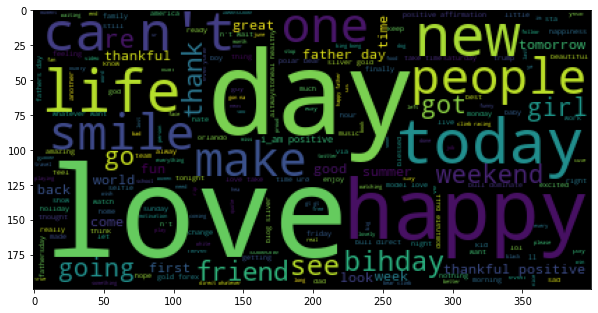

In [23]:
### Word cloud of all the text including the 2 classes :
wc = WordCloud()
plt.figure(figsize = (10, 10))
plt.imshow(wc.generate(whole_text))

In [24]:
word_counts = Counter(whole_text_tokens)
len(word_counts)

47370

In [25]:
print('10 most common terms are :')
word_counts.most_common()[0:10]

10 most common terms are :


[("'s", 3219),
 ('...', 2960),
 ('love', 2736),
 ('day', 2238),
 ("n't", 2228),
 ('``', 1866),
 ('happy', 1645),
 ('time', 1120),
 ('life', 1116),
 ('â\x80¦', 1088)]

In [26]:
text_list[0:5]

['father dysfunctional selfish drags kids dysfunction run',
 "thanks lyft credit ca n't use cause n't offer wheelchair vans pdx disapointed getthanked",
 'bihday majesty',
 'model love take time urð\x9f\x93± ð\x9f\x98\x99ð\x9f\x98\x8eð\x9f\x91\x84ð\x9f\x91 ð\x9f\x92¦ð\x9f\x92¦ð\x9f\x92¦',
 'factsguide society motivation']

In [27]:
X = pd.Series(text_list)
X.columns = ['Tweets']
X

0        father dysfunctional selfish drags kids dysfun...
1        thanks lyft credit ca n't use cause n't offer ...
2                                           bihday majesty
3        model love take time urð± ðððð ð...
4                            factsguide society motivation
                               ...                        
31957    ate isz youuu ðððððððð...
31958    see nina turner airwaves trying wrap mantle ge...
31959      listening sad songs monday morning otw work sad
31960      sikh temple vandalised calgary wso condemns act
31961                                         thank follow
Length: 31962, dtype: object

In [28]:
y = df['label']
y

0        0
1        0
2        0
3        0
4        0
        ..
31957    0
31958    0
31959    0
31960    1
31961    0
Name: label, Length: 31962, dtype: int64

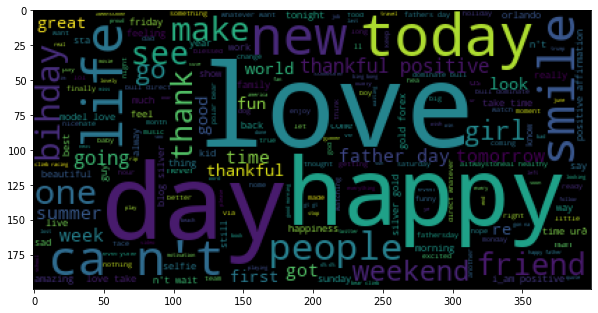

In [29]:
### Wordcloud of only '0' labels :
X_only0 = X[df1.Labels == 0]
X_whole_text0 = ' '.join(X_only0)
plt.figure(figsize = (10, 10))
plt.imshow(wc.generate(X_whole_text0))
plt.show()

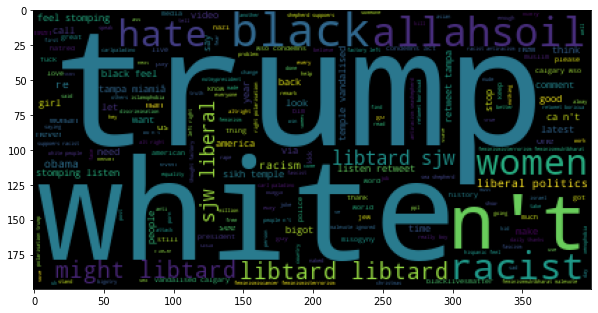

In [30]:
### Wordcloud of only '1' labels :
X_only1 = X[df1.Labels == 1]
X_whole_text1 = ' '.join(X_only1)
plt.figure(figsize = (10, 10))
plt.imshow(wc.generate(X_whole_text1))
plt.show()

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 21, shuffle = True)
print('X_train shape :', X_train.shape)
print('y_train shape :', y_train.shape)
print('=' * 30)
print('X_test shape :', X_test.shape)
print('y_test shape :', y_test.shape)

X_train shape : (25569,)
y_train shape : (25569,)
X_test shape : (6393,)
y_test shape : (6393,)


In [32]:
vect_tfidf = TfidfVectorizer()
vect_tfidf

TfidfVectorizer()

In [33]:
### Applying Tfidf vectorizer to the text data :
vect_tfidf.fit(X_train)

X_train_tdm = vect_tfidf.transform(X_train)
X_test_tdm = vect_tfidf.transform(X_test)

X_train_tdm

<25569x35735 sparse matrix of type '<class 'numpy.float64'>'
	with 193562 stored elements in Compressed Sparse Row format>

In [34]:
X_test_arr = X_test_tdm.toarray()
X_test_arr

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [35]:
X_train_arr = X_train_tdm.toarray()
X_train_arr

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [36]:
scaler = StandardScaler()
X_train_arr_scaled = scaler.fit_transform(X_train_arr)
X_test_arr_scaled = scaler.transform(X_test_arr)

In [37]:
X_train_df = pd.DataFrame(X_train_arr_scaled, columns = vect_tfidf.get_feature_names())
X_train_df

,00,000,000001,001,00am,00h30,00pm,01,0161,01926889917,...,ðºð¾ð,ðºð¾ñ,ð¼ð,ð½ð,ð¾ð,ð¾ð½ð,ð¾ð½ðµð,ð¾ñ,ó¾,ø¹ù
0,-0.040417,-0.026729,-0.008845,-0.006254,-0.006254,-0.006254,-0.006254,-0.015182,-0.006254,-0.006254,...,-0.008845,-0.006254,-0.006254,-0.008845,-0.012061,-0.008845,-0.006254,-0.008845,-0.055045,-0.006254
1,-0.040417,-0.026729,-0.008845,-0.006254,-0.006254,-0.006254,-0.006254,-0.015182,-0.006254,-0.006254,...,-0.008845,-0.006254,-0.006254,-0.008845,-0.012061,-0.008845,-0.006254,-0.008845,-0.055045,-0.006254
2,-0.040417,-0.026729,-0.008845,-0.006254,-0.006254,-0.006254,-0.006254,-0.015182,-0.006254,-0.006254,...,-0.008845,-0.006254,-0.006254,-0.008845,-0.012061,-0.008845,-0.006254,-0.008845,-0.055045,-0.006254
3,-0.040417,-0.026729,-0.008845,-0.006254,-0.006254,-0.006254,-0.006254,-0.015182,-0.006254,-0.006254,...,-0.008845,-0.006254,-0.006254,-0.008845,-0.012061,-0.008845,-0.006254,-0.008845,-0.055045,-0.006254
4,-0.040417,-0.026729,-0.008845,-0.006254,-0.006254,-0.006254,-0.006254,-0.015182,-0.006254,-0.006254,...,-0.008845,-0.006254,-0.006254,-0.008845,-0.012061,-0.008845,-0.006254,-0.008845,-0.055045,-0.006254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25564,-0.040417,-0.026729,-0.008845,-0.006254,-0.006254,-0.006254,-0.006254,-0.015182,-0.006254,-0.006254,...,-0.008845,-0.006254,-0.006254,-0.008845,-0.012061,-0.008845,-0.006254,-0.008845,-0.055045,-0.006254
25565,-0.040417,-0.026729,-0.008845,-0.006254,-0.006254,-0.006254,-0.006254,-0.015182,-0.006254,-0.006254,...,-0.008845,-0.006254,-0.006254,-0.008845,-0.012061,-0.008845,-0.006254,-0.008845,-0.055045,-0.006254
25566,-0.040417,-0.026729,-0.008845,-0.006254,-0.006254,-0.006254,-0.006254,-0.015182,-0.006254,-0.006254,...,-0.008845,-0.006254,-0.006254,-0.008845,-0.012061,-0.008845,-0.006254,-0.008845,-0.055045,-0.006254
25567,-0.040417,-0.026729,-0.008845,-0.006254,-0.006254,-0.006254,-0.006254,-0.015182,-0.006254,-0.006254,...,-0.008845,-0.006254,-0.006254,-0.008845,-0.012061,-0.008845,-0.006254,-0.008845,-0.055045,-0.006254


In [38]:
X_test_arr.shape

(6393, 35735)

In [39]:
X_train_arr.shape

(25569, 35735)

In [40]:
#vect_tfidf.vocabulary_

In [41]:
len(vect_tfidf.vocabulary_)

35735

In [42]:
#vect_tfidf.get_feature_names()

# Creating Model :

In [62]:
def generate_roc_auc_curve(estimater, X_test_arr_scaled):
    model = estimater
    model.fit(X_train_arr_scaled, y_train)
    proba_preds = model.predict_proba(X_test_arr_scaled)[:, 1]
    fps, tps, thresholds = roc_curve(y_test, proba_preds)
    auc = roc_auc_score(y_test, proba_preds)
    plt.plot(fps, tps, label = f'Roc_auc_curve with area under the curve {auc}')
    plt.title('Roc_auc_curve of simple logistic regression :')
    plt.legend(loc = (1, 1))
    plt.show()

In [44]:
def model_lg(estimator, X_train):
    model = estimator
    model.fit(X_train, y_train)
    predictions = model.predict(X_test_arr_scaled)
    print('Accuarcy score :\n', accuracy_score(y_test, predictions))
    print('=' * 100)
    print('Confusion matrix :\n', confusion_matrix(y_test, predictions))
    print('=' * 100)
    print('Classification report :\n', classification_report(y_test, predictions))

parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'penalty' : ['l2', 'none']}
grid_searchcv = GridSearchCV(estimator = LogisticRegression(), param_grid = parameters, cv = 4)
grid_searchcv.fit(X_train_arr_scaled, y_train)

# Logistic Regression with different parameters :

In [45]:
### LogisticRegression estimator :
model_lg(LogisticRegression(), X_train_arr_scaled)

Accuarcy score :
 0.9515094634756766
Confusion matrix :
 [[5790  120]
 [ 190  293]]
Classification report :
               precision    recall  f1-score   support

           0       0.97      0.98      0.97      5910
           1       0.71      0.61      0.65       483

    accuracy                           0.95      6393
   macro avg       0.84      0.79      0.81      6393
weighted avg       0.95      0.95      0.95      6393



In [46]:
### LogisticRegression estimator with "balanced" class weight :
model_lg(LogisticRegression(class_weight = 'balanced'), X_train_arr_scaled)

Accuarcy score :
 0.9433755670264352
Confusion matrix :
 [[5708  202]
 [ 160  323]]
Classification report :
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      5910
           1       0.62      0.67      0.64       483

    accuracy                           0.94      6393
   macro avg       0.79      0.82      0.81      6393
weighted avg       0.95      0.94      0.94      6393



In [47]:
model_lg(LogisticRegression(class_weight = 'balanced', C = 0.001), X_train_arr_scaled)

Accuarcy score :
 0.9583919912404192
Confusion matrix :
 [[5812   98]
 [ 168  315]]
Classification report :
               precision    recall  f1-score   support

           0       0.97      0.98      0.98      5910
           1       0.76      0.65      0.70       483

    accuracy                           0.96      6393
   macro avg       0.87      0.82      0.84      6393
weighted avg       0.96      0.96      0.96      6393



In [48]:
model_lg(LogisticRegression(class_weight = 'balanced', C = 0.01), X_train_arr_scaled)

Accuarcy score :
 0.9554199906147348
Confusion matrix :
 [[5797  113]
 [ 172  311]]
Classification report :
               precision    recall  f1-score   support

           0       0.97      0.98      0.98      5910
           1       0.73      0.64      0.69       483

    accuracy                           0.96      6393
   macro avg       0.85      0.81      0.83      6393
weighted avg       0.95      0.96      0.95      6393



In [49]:
model_lg(LogisticRegression(class_weight = 'balanced', C = 0.1), X_train_arr_scaled)

Accuarcy score :
 0.9490067261066791
Confusion matrix :
 [[5743  167]
 [ 159  324]]
Classification report :
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      5910
           1       0.66      0.67      0.67       483

    accuracy                           0.95      6393
   macro avg       0.82      0.82      0.82      6393
weighted avg       0.95      0.95      0.95      6393



In [50]:
model_lg(LogisticRegression(class_weight = 'balanced', C = 1), X_train_arr_scaled)

Accuarcy score :
 0.9433755670264352
Confusion matrix :
 [[5708  202]
 [ 160  323]]
Classification report :
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      5910
           1       0.62      0.67      0.64       483

    accuracy                           0.94      6393
   macro avg       0.79      0.82      0.81      6393
weighted avg       0.95      0.94      0.94      6393



In [51]:
model_lg(LogisticRegression(class_weight = 'balanced', C = 10), X_train_arr_scaled)

Accuarcy score :
 0.9366494603472548
Confusion matrix :
 [[5651  259]
 [ 146  337]]
Classification report :
               precision    recall  f1-score   support

           0       0.97      0.96      0.97      5910
           1       0.57      0.70      0.62       483

    accuracy                           0.94      6393
   macro avg       0.77      0.83      0.80      6393
weighted avg       0.94      0.94      0.94      6393



In [52]:
model_lg(LogisticRegression(class_weight = 'balanced', C = 100), X_train_arr_scaled)

Accuarcy score :
 0.9302361958391991
Confusion matrix :
 [[5591  319]
 [ 127  356]]
Classification report :
               precision    recall  f1-score   support

           0       0.98      0.95      0.96      5910
           1       0.53      0.74      0.61       483

    accuracy                           0.93      6393
   macro avg       0.75      0.84      0.79      6393
weighted avg       0.94      0.93      0.94      6393



In [53]:
model_lg(LogisticRegression(class_weight = 'balanced', C = 1000), X_train_arr_scaled)

Accuarcy score :
 0.9269513530423901
Confusion matrix :
 [[5567  343]
 [ 124  359]]
Classification report :
               precision    recall  f1-score   support

           0       0.98      0.94      0.96      5910
           1       0.51      0.74      0.61       483

    accuracy                           0.93      6393
   macro avg       0.74      0.84      0.78      6393
weighted avg       0.94      0.93      0.93      6393



In [54]:
model_lg(LogisticRegression(class_weight = 'balanced', C = 0.0001), X_train_arr_scaled)

Accuarcy score :
 0.9616768340372283
Confusion matrix :
 [[5836   74]
 [ 171  312]]
Classification report :
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      5910
           1       0.81      0.65      0.72       483

    accuracy                           0.96      6393
   macro avg       0.89      0.82      0.85      6393
weighted avg       0.96      0.96      0.96      6393



**class_weight = 'balanced', C = 0.0001 are the best parameters for LogisticRegression model.**

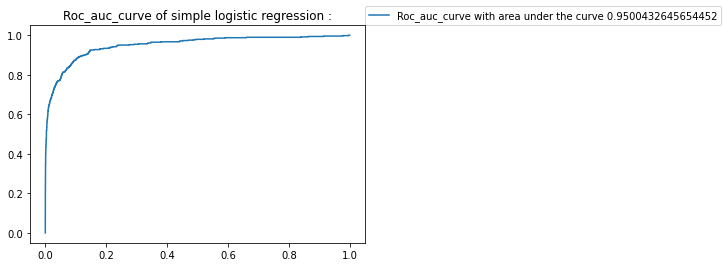

In [63]:
generate_roc_auc_curve(LogisticRegression(class_weight = 'balanced', C = 0.0001), X_test_arr_scaled)

In [ ]:
**Area under the curve is 0.95.**